* Based on 9 points ISW, as well as time interpolation for mdoel result to get one complete model result for data comparison.

In [1]:
from glob import glob
import datetime
import glob
import os
from datetime import datetime, timedelta
import datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io as sio
from salishsea_tools import (nc_tools,viz_tools,stormtools,tidetools, geo_tools)
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline

In [2]:
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

In [3]:
tracers = nc.Dataset('/results/SalishSea/nowcast/early-days/4-10oct14/SalishSea_1h_20141004_20141010_grid_T.nc')
tracers_6 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/SalishSea_1h_20141008_20141010_grid_T.nc')
tracers_reVi = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/SalishSea_1h_20141008_20141008_grid_T.nc')
tracers_reAll=nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/SalishSea_1h_20141008_20141008_grid_T.nc')

In [17]:
saline1=sio.loadmat('/ocean/jieliu/research/meopar/ONC_ferries/TWSB/TWSB_TSG20141007.mat') 
saline2=sio.loadmat('/ocean/jieliu/research/meopar/ONC_ferries/TWDP/TWDP_TSG20141007.mat') 

In [5]:
def find_dist(q, lon11, lat11, X, Y, bathy, longitude, latitude, saline_nemo):
    """
    Nine points inverse weighting interpolation
    """
    k=0
    value_rd = np.zeros(9)
    dist = np.zeros(9)
    weights = np.zeros(9)
    values = 0

    [x1, j1] = geo_tools.find_closest_model_point(lon11[q],lat11[q],\
                                        X,Y,land_mask = bathy.mask)

    interp_area = saline_nemo[x1-1:x1+2,j1-1:j1+2]
    if interp_area.size-np.count_nonzero(interp_area) >= 2:
        values = np.NaN
    for i in np.arange(x1-1,x1+2):
        for j in np.arange(j1-1,j1+2):
            dist[k]=geo_tools.haversine(lon11[q],lat11[q],longitude[i,j],latitude[i,j])
            weights[k]=1.0/dist[k]
            value_rd[k]=saline_nemo[i,j]*weights[k]
            values=values+value_rd[k]
            k+=1
            
    return values, weights

In [6]:
def salinity_fxn(saline,tracers,run_lower,run_upper,route = 'TWSB_TSG', model ='nowcast'):

    struct= (((saline[route])['output'])[0,0])['Practical_Salinity'][0,0]##need to modify
    salinity = struct['data'][0,0]
    time = struct['matlabTime'][0,0]
    lonn = struct['longitude'][0,0]
    latt = struct['latitude'][0,0]
    
    
    a=len(time)
    lon1=np.zeros([a,1])
    lat1=np.zeros([a,1])
    salinity1=np.zeros([a,1])
    time_matlab = []
    for i in np.arange(0,a):
        matlab_datenum = np.float(time[i])
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
        time_matlab.append(python_datetime)
        
        if(python_datetime >= run_lower) &(python_datetime <= run_upper):
            lon1[i]=lonn[i]
            lat1[i]=latt[i]
            salinity1[i]=salinity[i]
            
    mask=lon1[:,0]!=0
    lon1_2_4=lon1[mask]
    lat1_2_4=lat1[mask]
    salinity1_2_4=salinity1[mask]
    time1_2_4 = np.array(time_matlab)[mask]
    lon11=lon1_2_4[0:-1:20]
    lat11=lat1_2_4[0:-1:20]
    salinity11=salinity1_2_4[0:-1:20]
    time11 = time1_2_4[0:-1:20]
    
    bathy, X, Y = tidetools.get_SS2_bathy_data()

    latitude=tracers.variables['nav_lat'][:] 
    longitude=tracers.variables['nav_lon'][:] 
    saline_nemo = tracers.variables['vosaline']
    hour = run_lower.hour
    saline_nemo_dict = {}; values_dict = {};value_mean_dict = {};matrix = {}
    if route == 'TWSB_TSG':
        for hr, string in zip([hour-1,hour,hour+1],[str(hour-1),str(hour),str(hour+1)]):
            if model == 'nowcast':
                saline_nemo_dict[string] = saline_nemo[96+hr,1]
            else:
                saline_nemo_dict[string] = saline_nemo[hr,1]
            values_dict[string]=np.zeros([len(lon11),1])
            value_mean_dict[string]=np.zeros([len(lon11),1])
            matrix[string]=np.zeros([len(lon11),9])
    elif route == 'TWDP_TSG':
        for hr, string in zip([hour-1,hour,hour+1,hour+2],[str(hour-1),str(hour),str(hour+1),str(hour+2)]):
            if model == 'nowcast':
                saline_nemo_dict[string] = saline_nemo[96+hr,1]
            else:
                saline_nemo_dict[string] = saline_nemo[hr,1]
            values_dict[string]=np.zeros([len(lon11),1])
            value_mean_dict[string]=np.zeros([len(lon11),1])
            matrix[string]=np.zeros([len(lon11),9])

    for q in np.arange(len(lon11)):
        for key in saline_nemo_dict.keys(): 
            values_dict[key][q], matrix[key][q,:]=find_dist(q, lon11, lat11, X, Y,bathy, longitude, latitude, saline_nemo_dict[key])
            value_mean_dict[key][q]=values_dict[key][q]/sum(matrix[key][q])

    return lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean_dict,salinity11, salinity1_2_4,time11

In [7]:
def time_interpolation(low, mid, high, Hhigh,time,value_mean):
    """
    Linear time interpolation for different hourly model result
    """
    value_final = np.zeros(len(time))
    for i,j in enumerate(time):
        if (j > low) and (j<mid):
            value_final[i] = (value_mean[str(low.hour)][i]/((j-low).seconds/60) + \
                              value_mean[str(mid.hour)][i]/((mid-j).seconds/60))/\
                            (1/((j-low).seconds/60)+1/((mid-j).seconds/60))
        elif (j > mid) and (j<high):
            value_final[i] = (value_mean[str(mid.hour)][i]/((j-mid).seconds/60) + \
                              value_mean[str(high.hour)][i]/((high-j).seconds/60))/\
                            (1/((j-mid).seconds/60)+1/((high-j).seconds/60))
        elif (j > high) and (j<Hhigh):
            value_final[i] = (value_mean[str(high.hour)][i]/((j-high).seconds/60) + \
                              value_mean[str(Hhigh.hour)][i]/((Hhigh-j).seconds/60))/\
                            (1/((j-high).seconds/60)+1/((Hhigh-j).seconds/60))
        for t in [low, mid, high, Hhigh]:
            if j == t:
                value_final[i] = value_mean_DP[str(t.hour)][i]
    return value_final

In [8]:
def include_all(saline,tracers,run_lower,run_upper,low, mid, high, Hhigh,route ='TWSB_TSG',model ='nowcast'):
    """
    """
    lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean,salinity11,salinity1_2_4,time = salinity_fxn(saline,tracers,run_lower,run_upper,route =route,model = model)

    value_final = time_interpolation(low, mid, high, Hhigh,time,value_mean)
    return value_final,lon11,lon1_2_4,salinity1_2_4

In [9]:
run_date = datetime.datetime(2014,10,8)

In [10]:
## TWSB 
run_lower_SB = datetime.datetime(2014,10,8,2,15)
run_upper_SB = datetime.datetime(2014,10,8,3,40)

low_SB = datetime.datetime(2014,10,8,1,30)
mid_SB = datetime.datetime(2014,10,8,2,30)
high_SB = datetime.datetime(2014,10,8,3,32)
Hhigh_SB = datetime.datetime(2014,10,8,4,30)

value_final_SB_now,lon11_SB,lon1_2_4_SB,salinity_SB = include_all(saline1,tracers,run_lower_SB,run_upper_SB,low_SB,mid_SB,\
                                high_SB,Hhigh_SB,route ='TWSB_TSG',model = 'nowcast')
value_final_SB_6,lon11_SB,lon1_2_4_SB,salinity_SB = include_all(saline1,tracers_6,run_lower_SB,run_upper_SB,low_SB,mid_SB,\
                                high_SB,Hhigh_SB,route ='TWSB_TSG',model = 'bathy6')
value_final_SB_reVi,lon11_SB,lon1_2_4_SB,salinity_SB = include_all(saline1,tracers_reVi,run_lower_SB,run_upper_SB,low_SB,mid_SB,\
                                high_SB,Hhigh_SB,route ='TWSB_TSG',model = 'reVi')
value_final_SB_reAll,lon11_SB,lon1_2_4_SB,salinity_SB = include_all(saline1,tracers_reAll,run_lower_SB,run_upper_SB,low_SB,mid_SB,\
                                high_SB,Hhigh_SB,route ='TWSB_TSG',model = 'reAll')

In [18]:
## TWDP
run_lower_DP = datetime.datetime(2014,10,8,3,15)
run_upper_DP = datetime.datetime(2014,10,8,5,15)

low_DP = datetime.datetime(2014,10,8,2,30)
mid_DP = datetime.datetime(2014,10,8,3,30)
high_DP = datetime.datetime(2014,10,8,4,30)
Hhigh_DP = datetime.datetime(2014,10,8,5,30)

value_final_DP_now,lon11_DP,lon1_2_4_DP,salinity_Dp = include_all(saline2,tracers,run_lower_DP,run_upper_DP,low_DP,mid_DP,\
                                high_DP,Hhigh_DP,route ='TWDP_TSG',model = 'nowcast')
value_final_DP_6,lon11_DP,lon1_2_4_DP,salinity_DP = include_all(saline2,tracers_6,run_lower_DP,run_upper_DP,low_DP,mid_DP,\
                                high_DP,Hhigh_DP,route ='TWDP_TSG',model = 'bathy6')
value_final_DP_reVi,lon11_DP,lon1_2_4_DP,salinity_DP = include_all(saline2,tracers_reVi,run_lower_DP,run_upper_DP,low_DP,mid_DP,\
                                high_DP,Hhigh_DP,route ='TWDP_TSG',model = 'reVi')
value_final_DP_reAll,lon11_DP,lon1_2_4_DP,salinity_DP = include_all(saline2,tracers_reAll,run_lower_DP,run_upper_DP,low_DP,mid_DP,\
                                high_DP,Hhigh_DP,route ='TWDP_TSG',model = 'reAll')

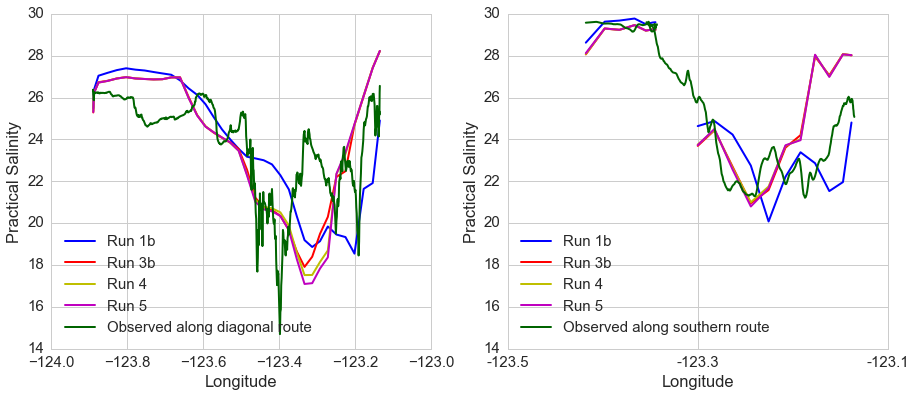

In [20]:
fig, axs = plt.subplots(1,2,figsize = (15,6))
ax = axs[0]
model_salinity_6rd_hour=ax.plot(lon11_DP,value_final_DP_now,'b',\
                                        linewidth=2, label="Run 1b" )
model_salinity_6rd_hour=ax.plot(lon11_DP,value_final_DP_6,'r',\
                                        linewidth=2, label="Run 3b" )
model_salinity_6rd_hour=ax.plot(lon11_DP,value_final_DP_reVi,'y',\
                                        linewidth=2, label="Run 4" )
model_salinity_6rd_hour=ax.plot(lon11_DP,value_final_DP_reAll,'m',\
                                        linewidth=2, label="Run 5" )
observation_salinity=ax.plot(lon1_2_4_DP,salinity_DP,'DarkGreen', linewidth=2, label="Observed along diagonal route")
ax.set_xlim(-124, -123)
ax = axs[1]
model_salinity_now=ax.plot(lon11_SB,value_final_SB_now,'b',\
                                        linewidth=2, label="Run 1b" )
model_salinity_6=ax.plot(lon11_SB,value_final_SB_6,'r',\
                                        linewidth=2, label="Run 3b" )
model_salinity_revi=ax.plot(lon11_SB,value_final_SB_reVi,'y',\
                                        linewidth=2, label="Run 4" )
model_salinity_reall=ax.plot(lon11_SB,value_final_SB_reAll,'m',\
                                        linewidth=2, label="Run 5" )
observation_salinity=ax.plot(lon1_2_4_SB,salinity_SB,'DarkGreen', linewidth=2, label="Observed along southern route")
ax.set_xlim(-123.5, -123.1)
ax.set_xticks([-123.5,-123.3,-123.1])
ax.set_xticklabels([-123.5,-123.3,-123.1])
for ax in axs:
    ax.set_ylim(14, 30)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Practical Salinity')
    ax.legend(loc = 'best')

In [21]:
lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean,salinity11,salinity1_2_4,time = salinity_fxn(saline1,tracers,run_lower_SB,run_upper_SB,route ='TWSB_TSG',model = 'nowcast')

[-123.41772307] [ 48.71861923] 83.0
[-123.39789061] [ 48.73043204] 76.0
[-123.38239537] [ 48.74406655] 59.0
[-123.36650452] [ 48.75805855] 78.0
[-123.35469159] [ 48.77262522] 52.0
[-123.34769397] [ 48.78861808] 65.0
[-123.3445] [ 48.80547626] 80.0
[-123.3432] [ 48.82203546] 60.0
[-123.35013131] [ 48.83759544] 74.0
[-123.35163593] [ 48.85295627] 39.625
[-123.34154386] [ 48.8595] 21.0
[-123.32702957] [ 48.8579399] --
[-123.30971169] [ 48.86220605] 23.0
[-123.30007202] [ 48.87514249] 39.0
[-123.28242326] [ 48.88713837] 128.0
[-123.26343108] [ 48.89948825] 179.0
[-123.24424102] [ 48.91198128] 146.0
[-123.22557338] [ 48.92435108] 138.0
[-123.20780784] [ 48.93696814] 127.0
[-123.19199094] [ 48.95068583] 122.0
[-123.17669843] [ 48.96445677] 115.0
[-123.1617492] [ 48.9781508] 111.0
[-123.14737687] [ 48.9924847] 82.0
[-123.13844054] [ 49.00233964] 42.0


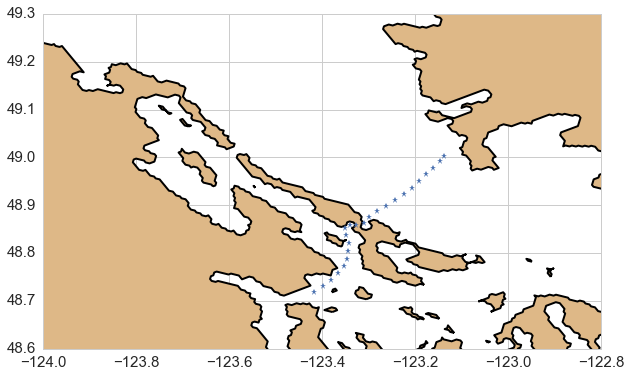

In [18]:
fig,ax = plt.subplots(1,1,figsize = (10,6))
viz_tools.plot_land_mask(ax,bathy,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, bathy, coords = 'map')
ax.set_xlim([-124.,-122.8])
ax.set_ylim([48.6,49.3])
ax.plot(lon11,lat11,'*')
bathy2,X,Y, = tidetools.get_SS2_bathy_data()
for lon, lat in zip(lon11,lat11):
    [j,i] = geo_tools.find_closest_model_point(lon,lat,X,Y)
    print(lon,lat,bathy2[j,i])

In [22]:
0.75*60

45.0